In [1]:
import torch
import data as Data
import model as Model
import argparse
import logging
import core.logger as Logger
import core.metrics as Metrics
import os
import numpy as np
from data import dataset

parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='config/sr_sr3_256_256_val.json',
                    help='JSON file for configuration')
parser.add_argument('-p', '--phase', type=str, choices=['train', 'val'], 
                    help='Run either train(training) or val(generation)', default='val')
parser.add_argument('-gpu', '--gpu_ids', type=str, default=None)
parser.add_argument('-debug', '-d', action='store_true')
parser.add_argument('-enable_wandb', action='store_true')
parser.add_argument('-log_wandb_ckpt', action='store_true')
parser.add_argument('-log_eval', action='store_true')

# parse configs
# args = parser.parse_args()
args =parser.parse_known_args()[0]
opt = Logger.parse(args)
# Convert to NoneDict, which return None for missing key.
opt = Logger.dict_to_nonedict(opt)

# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

Logger.setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
Logger.setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')
logger.info(Logger.dict2str(opt))

# model
diffusion = Model.create_model(opt)
logger.info('Initial Model Finished')

# Train
current_step = diffusion.begin_step
current_epoch = diffusion.begin_epoch
n_iter = opt['train']['n_iter']

if opt['path']['resume_state']:
    logger.info('Resuming training from epoch: {}, iter: {}.'.format(
        current_epoch, current_step))

diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

val_set = dataset.create_dataset(opt['datasets']['val'], 'valid')
val_loader = Data.create_dataloader(
    val_set, opt['datasets']['val'], 'val')
logger.info('Initial Dataset Finished')

23-12-27 15:23:54.376 - INFO:   name: sr_NUSNMR
  phase: val
  gpu_ids: [0]
  path:[
    log: experiments/sr_NUSNMR_231227_152354/logs
    tb_logger: experiments/sr_NUSNMR_231227_152354/tb_logger
    results: experiments/sr_NUSNMR_231227_152354/results
    checkpoint: experiments/sr_NUSNMR_231227_152354/checkpoint
    resume_state: experiments/sr_NUSNMR_231226_232924/checkpoint/I140000_E14
    experiments_root: experiments/sr_NUSNMR_231227_152354
  ]
  datasets:[
    train:[
      name: NUSNMR
      mode: LRHR
      dataroot: ./
      datatype: img
      batch_size: 4
      num_workers: 8
      use_shuffle: True
      data_len: 40000
    ]
    val:[
      name: NUSNMR
      mode: LRHR
      dataroot: ./
      datatype: img
      data_len: 10
    ]
  ]
  model:[
    which_model_G: sr3
    finetune_norm: False
    unet:[
      in_channel: 2
      out_channel: 2
      inner_channel: 64
      channel_multiplier: [1, 2, 4, 8, 8]
      attn_res: [16]
      res_blocks: 2
      dropout: 0.02
 

export CUDA_VISIBLE_DEVICES=0


23-12-27 15:24:03.463 - INFO: Loading pretrained model for G [experiments/sr_NUSNMR_231226_232924/checkpoint/I140000_E14] ...
23-12-27 15:24:04.499 - INFO: Network G structure: GaussianDiffusion, with parameters: 103,201,218
23-12-27 15:24:04.501 - INFO: GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): Swish()
      (3): Linear(in_features=256, out_features=64, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=64, out_features=64, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(32, 64, eps=1e-05, affine=True)
              (1): Swi

sampling loop time step: 100%|██████████| 2000/2000 [14:39<00:00,  2.28it/s]
/mnt/DATA1/chenbo/code/NUS_Diffusion/model/model.py:108: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  out_dict['LR'] = self.data['LR'].detach().float().cpu()


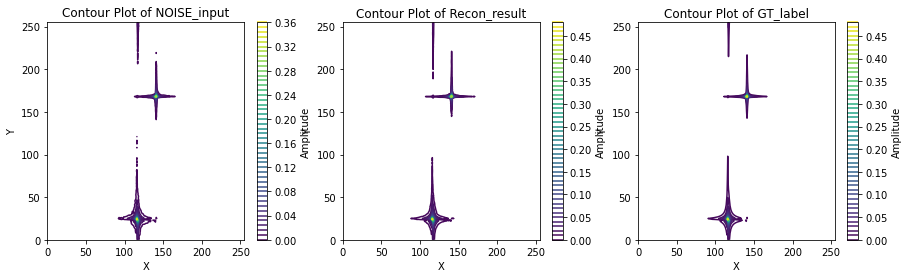

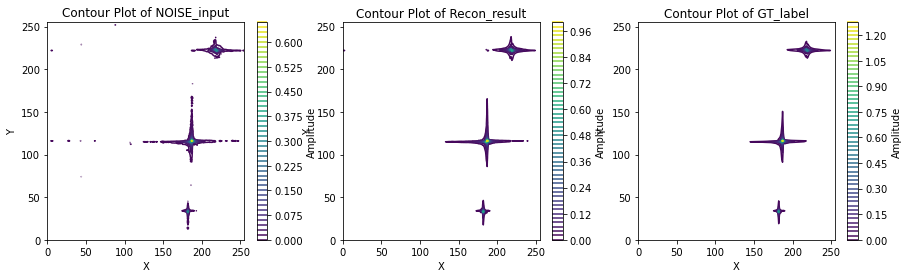

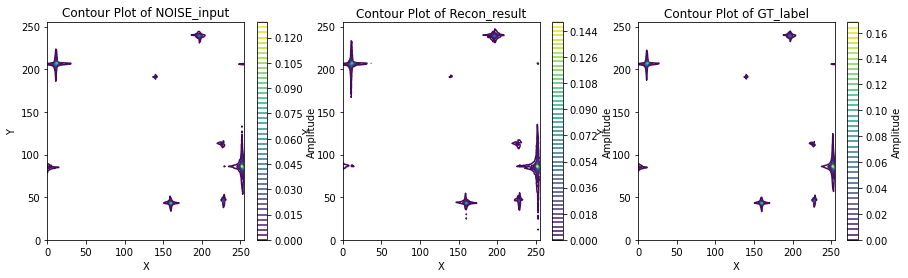

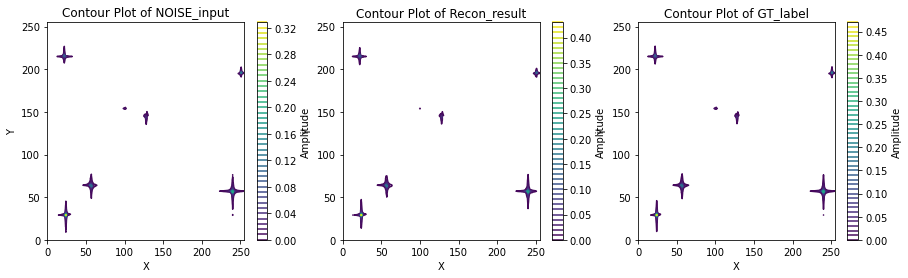

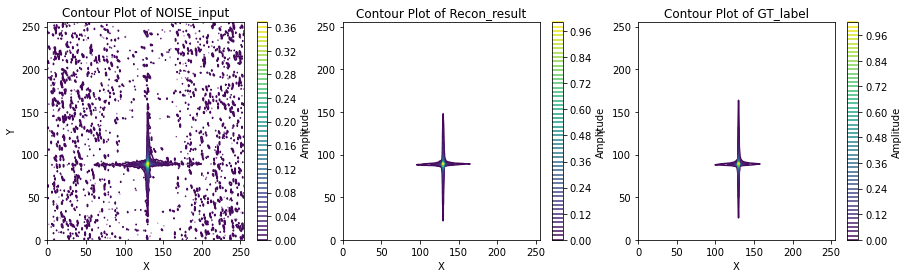

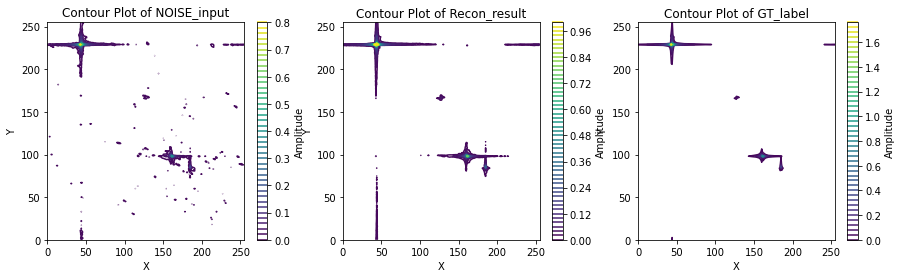

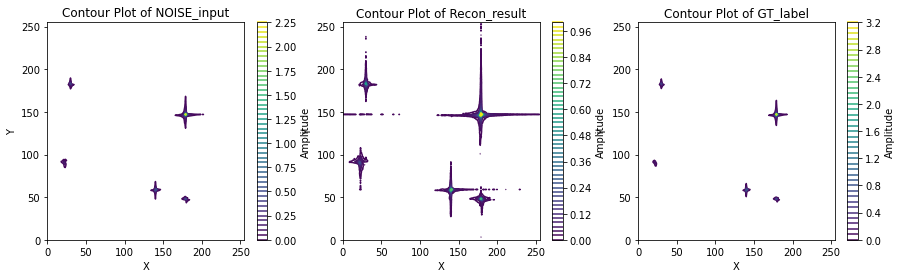

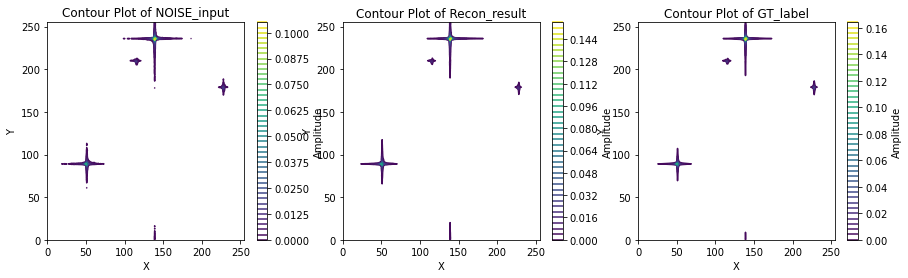

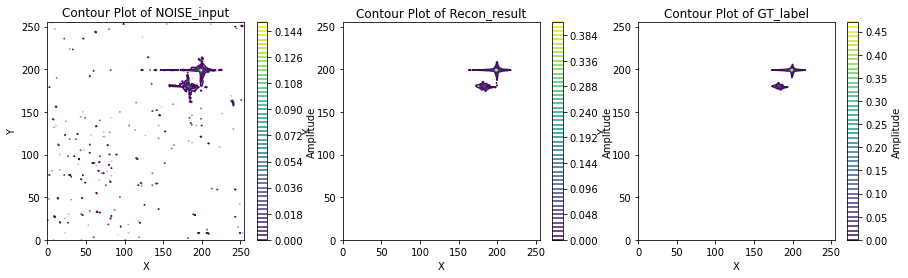

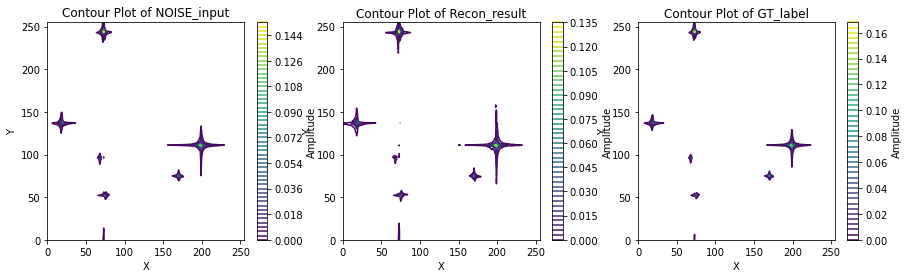

In [2]:
avg_mse = 0.0
idx = 0
result_path = '{}/{}'.format(opt['path']
                                ['results'], current_epoch)
os.makedirs(result_path, exist_ok=True)

diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')
for _,  val_data in enumerate(val_loader):
    idx += 1
    diffusion.feed_data(val_data)
    diffusion.test(continous=False)
    visuals = diffusion.get_current_visuals()

    bsz = visuals['HR'].shape[0]
    for i in range(bsz):
        sr_img = torch.complex(visuals['SR'][-bsz+i, 0], visuals['SR'][-bsz+i, 1]).squeeze().float().cpu().numpy()
        hr_img = torch.complex(visuals['HR'][i, 0], visuals['HR'][i, 1]).squeeze().float().cpu().numpy()
        lr_img = visuals['LR'][i].squeeze().float().cpu().numpy()
        fake_img = torch.complex(visuals['INF'][i, 0], visuals['INF'][i, 1]).squeeze().float().cpu().numpy()

        Metrics.plot_contour(
            nus_spec=fake_img,
            recon_spec=sr_img,
            label_spec=hr_img,
            fig_num=i)

        # generation
        eval_mse = Metrics.calculate_mse(sr_img, hr_img)
        avg_mse += eval_mse
avg_mse = avg_mse / (idx*bsz)